<a href="https://colab.research.google.com/github/jackylmw/Week3-Machine_Learning/blob/Assignment3_JackyLam/JackyLam_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Feature Engineering

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import librosa.display
import soundfile


import warnings; warnings.filterwarnings('ignore')

## Merge EmoDB and RAVDESS

In [3]:

actor_id = {
    "03": "25",
    "08": "26",
    "10": "27",
    "09": "28",
    "11": "29",
    "13": "30",
    "12": "31",
    "14": "32",
    "15": "33",
    "16": "34",
}

emotion = {"W": "05",
           "E": "07",
           "A": "06",
           "F": "03",
           "T": "04",
           "N": "01",
           "L": "09"}

versions = {
    "a": "01",
    "b": "02",
    "c": "03",
    "d": "04",
    "e": "05",
    "f": "06"}

In [4]:
import os

os.chdir(os.path.dirname("/content/drive/MyDrive/IAT481-Assignment2/wav"))

if not os.path.exists("./RAVDESS"):
    os.mkdir("./RAVDESS")

files = os.listdir("./wav")

for f in files:
    new_f = (
        "03-01-"
        + emotion[f[5]]
        + "-01-"
        + f[2:5]
        + "-"
        + versions[f[6]]
        + "-"
        + actor_id[f[0:2]]
        + ".wav"
    )

    if not os.path.exists("./RAVDESS/Actor_" + actor_id[f[0:2]]):
        os.mkdir("./RAVDESS/Actor_" + actor_id[f[0:2]])

    ravdess_emotion=new_f.split("-")[2]
    if (ravdess_emotion == '02' or ravdess_emotion == '08' or ravdess_emotion == '09'):
        os.remove("./wav/" + f)
        continue


    os.rename("./wav/" + f, "./RAVDESS/Actor_" + actor_id[f[0:2]] + "/" + new_f)

Now, the bored, calm and surprised audio files are removed from the dataset.

# Feature Extration


The feature extration methods provided at tutorial serve as a good example. I will use them as a starting point for my own implementation.

We will get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Then we will save them into one feature array and one local file.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; The number of mel frequency n_mels=128

**MFCC**: Will produce 40 MFCCs; The number of coefficients to return at n_mfcc=40.

In [ ]:

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate, n_mels = 128):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate, n_mfcc = 40):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
    return mfc_coefficients

In [ ]:

def get_features(file, n_mels=128, n_mfcc=40):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate,n_mels)
        mfc_coefficients = feature_mfcc(waveform, sample_rate,n_mfcc)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

## Load the dataset

In [ ]:
#Emotions in the RAVDESS dataset
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [ ]:
def get_file_list(file_path, fileList):
    """
    Get the list of files in the given directory.
    """
    newFilePath = file_path
    if os.path.isfile(file_path):
        if ".wav" in file_path:
            fileList.append(file_path)
    elif os.path.isdir(file_path):
        for s in os.listdir(file_path):
            newFilePath = os.path.join(file_path, s)
            get_file_list(newFilePath, fileList)
    return fileList


In [ ]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT481-Assignment2/RAVDESS/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        print('\r' + f' Processed {count}/{1889} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms

    return np.array(X), np.array(y)

In [ ]:
features, emotions = load_data()

 Processed 1889/1889 audio samples 

In [ ]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display


#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display

features_df


Audio samples represented: 1889
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.534015,0.496223,0.534798,0.574099,0.645865,0.655817,0.643382,0.653531,0.671589,0.695924,...,-1.379127,1.892208,-0.281603,1.833495,2.770707,5.611548,4.441547,4.359780,2.932198,3.128985
1,0.528473,0.586390,0.616468,0.632136,0.628074,0.582471,0.589270,0.608324,0.640730,0.659047,...,-1.755571,4.502727,1.403460,3.257668,3.779081,3.526422,1.375062,3.393569,2.990325,4.247328
2,0.580232,0.550433,0.543916,0.601567,0.695012,0.735208,0.634582,0.609333,0.632545,0.610934,...,-1.049695,1.278303,-1.043539,0.986319,2.251187,3.698765,7.107568,7.854966,5.507263,4.954595
3,0.626555,0.608605,0.579560,0.569777,0.618980,0.687848,0.695325,0.633374,0.566604,0.556549,...,0.426347,3.759364,3.343401,1.887519,0.987106,1.549861,0.637748,2.245790,-0.154757,1.477122
4,0.548495,0.515951,0.554068,0.605764,0.616290,0.641597,0.639985,0.620051,0.601553,0.562123,...,2.789721,4.370572,3.298380,2.287989,1.137115,2.690198,0.571669,0.609685,1.258690,0.946380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,0.664177,0.633587,0.590743,0.601933,0.623831,0.643299,0.671203,0.668196,0.683204,0.658824,...,5.234397,5.000974,4.120270,3.053776,2.119890,2.965642,2.442994,2.014850,3.167833,4.008449
1885,0.697806,0.658317,0.614802,0.639169,0.717383,0.743908,0.781170,0.749796,0.722322,0.715267,...,-1.211285,0.060299,-1.140080,0.446977,0.614657,0.430341,0.332445,-0.197219,0.797524,2.606972
1886,0.628023,0.596604,0.643935,0.655228,0.659819,0.725635,0.808151,0.814369,0.771093,0.722508,...,-1.125915,0.213711,-1.729091,0.776150,0.564957,2.507703,0.997836,0.844502,-0.108339,2.037053
1887,0.630163,0.652205,0.637307,0.684746,0.764458,0.795282,0.819000,0.802949,0.774911,0.734925,...,-2.221260,-0.709731,-1.652230,-1.931097,-1.620286,1.130693,0.274002,2.252403,2.537369,3.869971


We save the data into csv files instead of excel.

In [ ]:
features_df.to_csv('featuresRavdess_EmoDB.csv')
emotions_df.to_csv('emotionsRavdess_EmoDB.csv')

# Dataset Extration

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import librosa.display
import soundfile

import warnings; warnings.filterwarnings('ignore')

In [ ]:
features=pd.read_csv('featuresRavdess_EmoDB.csv',index_col=0)
emotions=pd.read_csv('emotionsRavdess_EmoDB.csv',index_col=0)

In [ ]:
print(features.shape)
print(emotions.shape)

(1889, 180)
(1889, 1)


In [ ]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.534015,0.496223,0.534798,0.574099,0.645865,0.655817,0.643382,0.653531,0.671589,0.695924,...,-1.379127,1.892208,-0.281603,1.833495,2.770707,5.611548,4.441547,4.359780,2.932198,3.128985
1,0.528473,0.586390,0.616468,0.632136,0.628074,0.582471,0.589270,0.608324,0.640730,0.659047,...,-1.755571,4.502727,1.403460,3.257668,3.779081,3.526422,1.375063,3.393569,2.990325,4.247328
2,0.580232,0.550433,0.543916,0.601567,0.695012,0.735208,0.634582,0.609333,0.632545,0.610934,...,-1.049695,1.278303,-1.043539,0.986319,2.251187,3.698765,7.107568,7.854966,5.507263,4.954595
3,0.626555,0.608605,0.579560,0.569777,0.618980,0.687848,0.695325,0.633374,0.566604,0.556549,...,0.426347,3.759364,3.343401,1.887519,0.987106,1.549861,0.637748,2.245790,-0.154757,1.477122
4,0.548495,0.515951,0.554068,0.605764,0.616290,0.641597,0.639985,0.620051,0.601553,0.562123,...,2.789721,4.370572,3.298380,2.287989,1.137115,2.690198,0.571669,0.609685,1.258690,0.946380


See the class balance

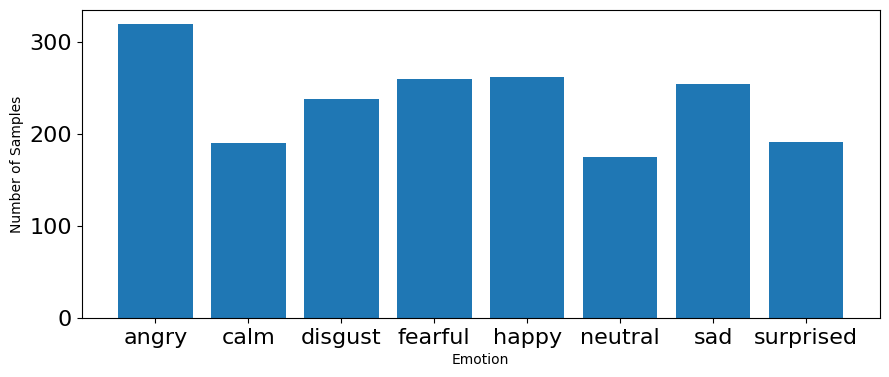

In [ ]:

# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(8), height=count)
plt.xticks(ticks=range(8), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

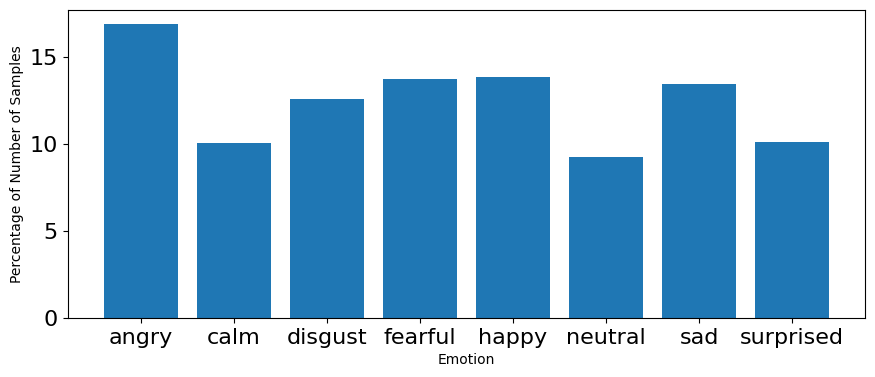

In [ ]:

# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(8), height=count * 100.0 / emotions.shape[0])
plt.xticks(ticks=range(8), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Percentage of Number of Samples')
plt.show()

As we see from the results, our sample is slightly imbalanced, with angry (17%) as the dominant class, and neutral (9%). But the other 7 classes are balanced and around 10%. I don't think this level of imbalance would be a problem for our model. So let's continue.

## Feature Scaling

In [ ]:
features.describe()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
count,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,...,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000
mean,0.624100,0.621168,0.627631,0.639087,0.654466,0.662478,0.665196,0.659409,0.662351,0.652766,...,0.147643,0.798415,0.060232,0.999877,0.603800,0.765466,0.615961,0.890651,0.477340,1.010083
std,0.088495,0.093485,0.095625,0.096221,0.099161,0.096010,0.091744,0.087647,0.087862,0.087505,...,2.736114,2.722039,2.464363,2.444048,2.209140,2.222496,2.106648,2.080707,2.063596,2.152659
min,0.359126,0.340238,0.299362,0.303413,0.325203,0.355683,0.303241,0.328593,0.387703,0.333790,...,-5.994778,-5.506482,-6.775739,-4.391046,-6.343026,-6.151188,-5.380692,-4.492407,-4.573128,-4.713404
25%,0.563791,0.555605,0.554669,0.565527,0.576797,0.590737,0.596491,0.597207,0.598662,0.590422,...,-1.651782,-1.011328,-1.584406,-0.666178,-0.889358,-0.726043,-0.871171,-0.521835,-0.967876,-0.463241
50%,0.631354,0.625523,0.636642,0.651015,0.669446,0.680553,0.679703,0.673709,0.672524,0.664520,...,-0.319704,0.314290,-0.216921,0.652395,0.272779,0.457207,0.417592,0.687100,0.176616,0.737483
75%,0.691912,0.693833,0.701409,0.716808,0.734573,0.738715,0.736337,0.728685,0.731247,0.719856,...,1.383464,2.121409,1.353171,2.305334,1.867801,2.148517,1.853265,2.075861,1.670015,2.162317
max,0.841939,0.845382,0.841940,0.837596,0.888018,0.874122,0.866876,0.862732,0.854940,0.838494,...,14.914500,14.374680,13.404589,13.804985,9.571485,11.548025,10.993403,10.890314,11.405354,13.102063


In [ ]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.iloc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.iloc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.iloc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features)

12 Chromagram features:           min = 0.286,     max = 0.888,     mean = 0.647,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.076,     deviation = 8.759

40 MFCC features:                 min = -873.242,    max = 121.174,    mean = -12.370,    deviation = 88.765


We try both `MinMax` scaling and `Standard` scaling.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

stand_scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = stand_scaler.fit_transform(features_scaled)

min_max_scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = min_max_scaler.fit_transform(features_minmax)

In [ ]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.117,     max = 2.462,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.418,     max = 36.981,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -5.024,    max = 7.015,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.606,     deviation = 0.180

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.019,     deviation = 0.062

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.174


Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling

Have a look at the labels.

In [ ]:
print(f"Shape of labels: {emotions.shape}")
emotions.head()

Shape of labels: (1889, 1)


,0
0,happy
1,happy
2,angry
3,angry
4,happy


# Model Exploraion

### Training: The 80/20 Split and Validation
In order to compare models, we'll have to evaluate their performance. The simplest method to do so is to train a model on a portion of our dataset and test it on the remainder. We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

More accurately, the proper modality for training and scoring a model is to
1. Fit/train our model on a _training_ set,
2. Evaluate the model on a _validation_ set to tune the hyperparameters for better performance,
3. Finally score our model's true performance - its **generalizability** - against a _test_ set, aka the hold-out set.
4. Repeat from 2. **Do not tune the model to score well on the test set**.

Different set ratios are used in this approach - a usual example is 60/20/20 train/validation/test.For simplicity, we're going to start with an 80/20 train/test split. The model will be trained on all the training data, and we will check its performance on the test data.

In [ ]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=69
)

## Classical Machine Learning Models

- Support Vector Machine(SVM)
- K-Nearest Neighbors
- Random Forest Classifier.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
4,RandomForestClassifier,64.02%
0,KNeighborsClassifier,56.08%
1,SVC,52.12%
2,SVC RBF kernel,51.59%
3,DecisionTreeClassifier,45.77%
6,GaussianNB,36.24%
7,QuadraticDiscriminantAnalysis,25.13%
5,AdaBoostClassifier,22.75%


## Support Vector Machine Classifier

### Baseline Model

In [ ]:
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=69
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 45.24%


### Scores on different scaled dataset

In [ ]:
def get_score_on_scaled_data(model, X, y):
    X_train, X_test, y_train, y_test =train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


In [ ]:
X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

for X in X_list:
    model = SVC(
        C=10,  #higher the value tighter the margin
        gamma='auto',
        kernel='rbf',
        random_state=69
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(train_score, test_score)

1.0 0.4523809523809524
0.8325612177365983 0.6455026455026455
0.44209133024487096 0.37037037037037035


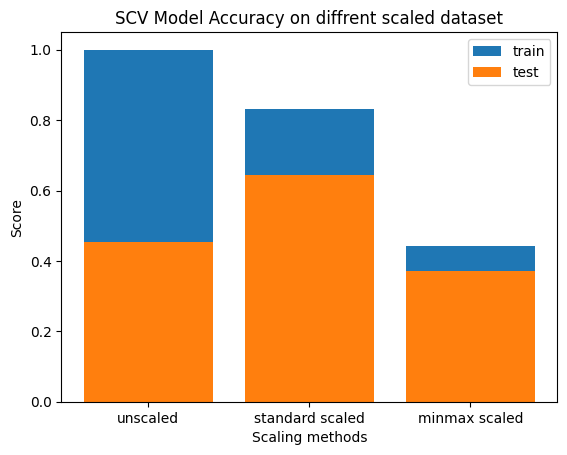

In [ ]:
# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("SCV Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


As we can see:
- The model on standard scaled data performs the best, with training score of 83% and validation score of 64%.
- The model on unscaled data works in the middle, and it signals that the model is overfitting on training dataset, with training score of 100% and validation score of 45%.
- The model on min_max scaled data gets the lowest score, with training score of 44% and validation score of 37%.

### Cross validation

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

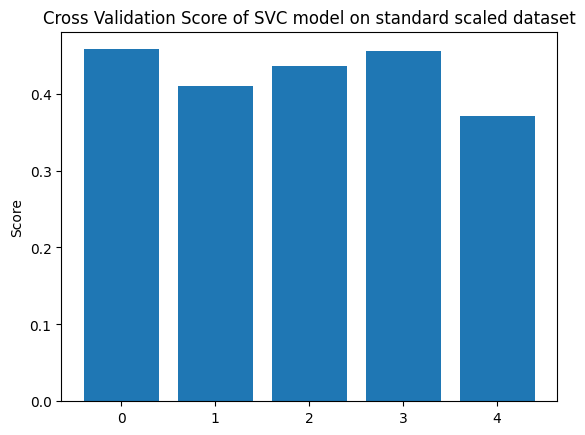

Mean= 0.42612240888102954 
Variance= 0.001039323514650627


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=69
)
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of SVC model on standard scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

Summary:
- For SVC model, standard scaling is the best and the mean best test score is 42.6% after 5 cross validation.

### Hyperparameters Optimization

GridSearchCV is brute-force search over specified parameter values for an estimator. GridSearchCV has already implemented a “fit” and a “score” method. And it will run using the given params, e.g., models, scorling.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = SVC(
    random_state=69
)
parameters = {
    'kernel':('linear', 'rbf','sigmoid'),
    'C':[0.1, 1, 10, 100],
    'gamma': ('scale', 'auto')
    }
# parameters = {
#     'kernel':['rbf'],
#     'C':[1, 10],
#     'gamma': ['auto']
#     }


grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, error_score="raise")
grid.fit(features_scaled, emotions)
# By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.4s
[CV] END .................C=0.1, gamma=scale, k

GridSearchCV(error_score='raise', estimator=SVC(random_state=69),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             verbose=2)

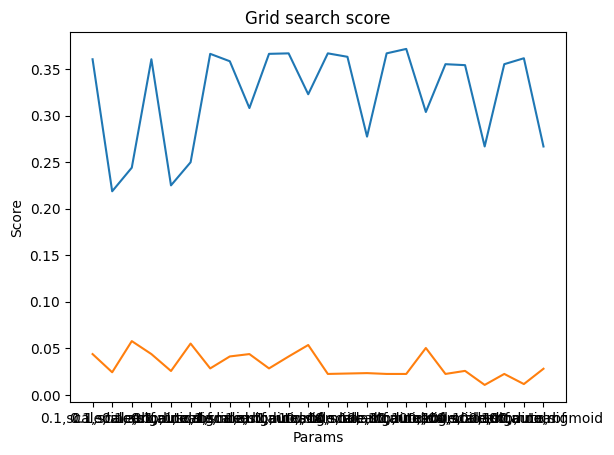

In [ ]:
def plot_grid_search(cv_results):
    params = cv_results["params"]
    x_names = []
    for dct in params:
        k = ",".join(str(v) for k,v in dct.items())
        # print(k)
        x_names.append(k)
    mean_test_scores = cv_results["mean_test_score"]
    std_test_scores = cv_results["std_test_score"]
    plt.plot(x_names, mean_test_scores, label="Mean")
    plt.plot(x_names, std_test_scores, label="Std")
    plt.title("Grid search score")
    plt.ylabel("Score")
    plt.xlabel("Params")
    plt.show()

plot_grid_search(grid.cv_results_)

Best params={'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}, score=0.371606809537844


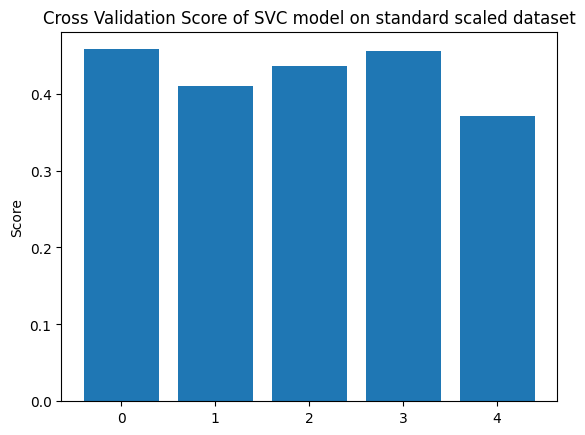

Mean= 0.42612240888102954 
Variance= 0.001039323514650627


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

print(f"Best params={grid.best_params_}, score={grid.best_score_}")

k_folds = KFold(n_splits = 5)
model = grid.best_estimator_
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of SVC model on standard scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

## KNN

### Baseline Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 68.56%
Default kNN Model's accuracy on test set is 53.17%

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 57.14%


### Scores on different scaled dataset

In [ ]:
def get_score_on_scaled_data(model, X, y):
    X_train, X_test, y_train, y_test =train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


In [ ]:
X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

for X in X_list:
    model = KNeighborsClassifier(
        n_neighbors = 5,
        weights = 'distance',
        algorithm = 'brute',
        n_jobs=4
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(train_score, test_score)

1.0 0.5714285714285714


1.0 0.6005291005291006
1.0 0.6243386243386243


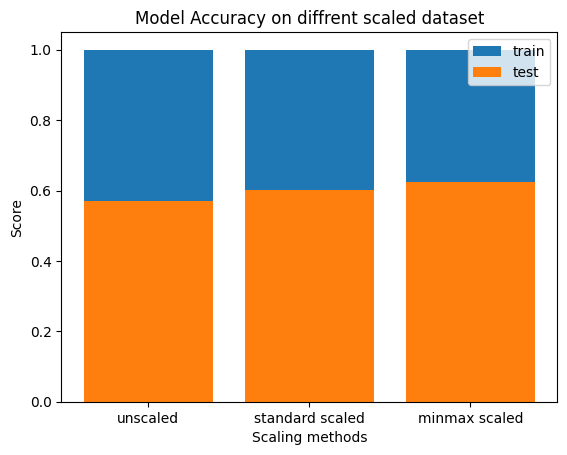

In [ ]:
# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


As we can see:
- The model on min_Max scaled data performs the best, with training score of 100% and validation score of 62%.
- The model on standard data works in the middle, with training score of 100% and validation score of 60%.
- The model on unscaled data gets the lowest score, with training score of 100% and validation score of 57%.

### Cross validation

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

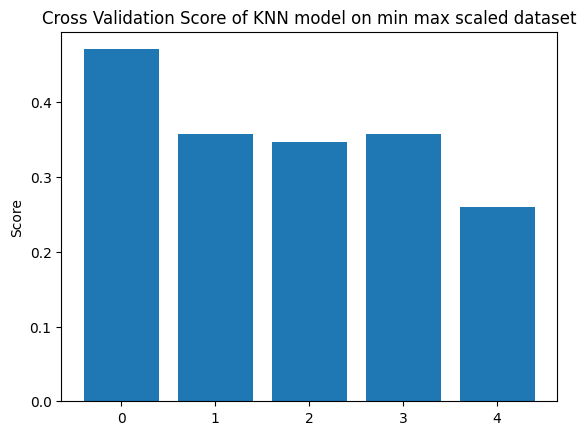

Mean= 0.35833859626963077 
Variance= 0.004498488320739966


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)
scores = cross_val_score(model, features_minmax, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of KNN model on min max scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

Summary:
- For KNN model, min max scaling is the best and the mean best test score is 35.8% after 5 cross validation.

### Hyperparameters Optimization

GridSearchCV is brute-force search over specified parameter values for an estimator. GridSearchCV has already implemented a “fit” and a “score” method. And it will run using the given params, e.g., models, scorling.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier()
parameters = {
    'weights':('uniform', 'distance'),
    "n_neighbors": range(1,100,20),
    'algorithm':["auto", "kd_tree", "brute"],
    'leaf_size': range(1, 100, 30)
    }

grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, error_score="raise")
grid.fit(features_minmax, emotions)
# By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_ne

GridSearchCV(error_score='raise', estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree', 'brute'],
                         'leaf_size': range(1, 100, 30),
                         'n_neighbors': range(1, 100, 20),
                         'weights': ('uniform', 'distance')},
             verbose=2)

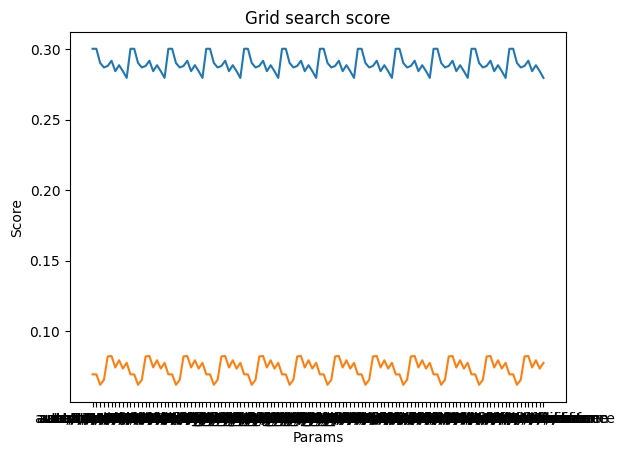

In [ ]:
def plot_grid_search(cv_results):
    params = cv_results["params"]
    x_names = []
    for dct in params:
        k = ",".join(str(v) for k,v in dct.items())
        # print(k)
        x_names.append(k)
    mean_test_scores = cv_results["mean_test_score"]
    std_test_scores = cv_results["std_test_score"]
    plt.plot(x_names, mean_test_scores, label="Mean")
    plt.plot(x_names, std_test_scores, label="Std")
    plt.title("Grid search score")
    plt.ylabel("Score")
    plt.xlabel("Params")
    plt.show()

plot_grid_search(grid.cv_results_)

Best params={'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}, score=0.3001263104711381


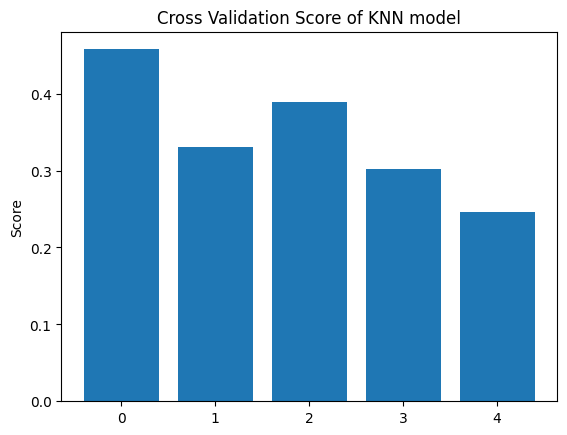

Mean= 0.34510406579372094 
Variance= 0.005275323609564346


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

print(f"Best params={grid.best_params_}, score={grid.best_score_}")

k_folds = KFold(n_splits = 5)
model = grid.best_estimator_
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of KNN model")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

## Random forest


### Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 61.64%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 62.70%


### Scores on different scaled dataset

In [ ]:
def get_score_on_scaled_data(model, X, y):
    model = RandomForestClassifier(
        n_estimators = 500,
        criterion ='entropy',
        warm_start = True,
        max_features = 'sqrt',
        oob_score = True, # more on this below
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


In [ ]:
X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

for X in X_list:
    model = RandomForestClassifier(
        n_estimators = 500,
        criterion ='entropy',
        warm_start = True,
        max_features = 'sqrt',
        oob_score = True, # more on this below
        random_state=69
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(train_score, test_score)

1.0 0.626984126984127
1.0 0.626984126984127
1.0 0.626984126984127


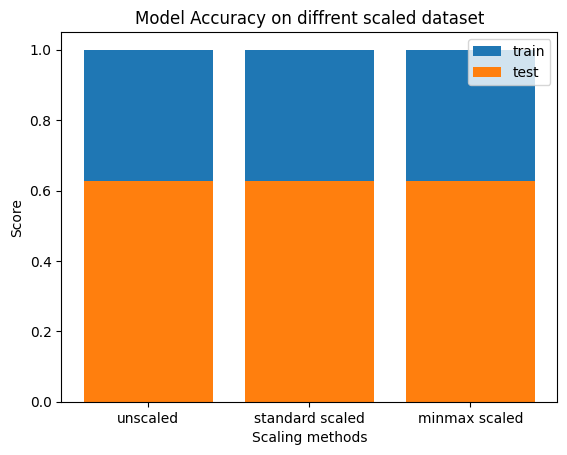

In [ ]:
# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


As we can see:
- All type of scaling data is the same, with training score of 100% and validation score of 63%.

### Cross validation

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

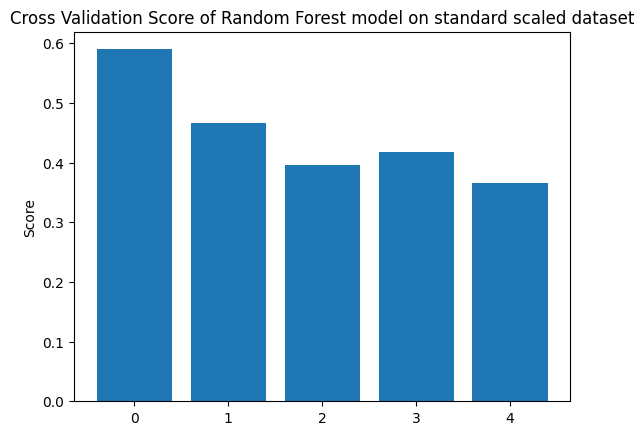

Mean= 0.44728362314569214 
Variance= 0.0061384231020258475


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest model on standard scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

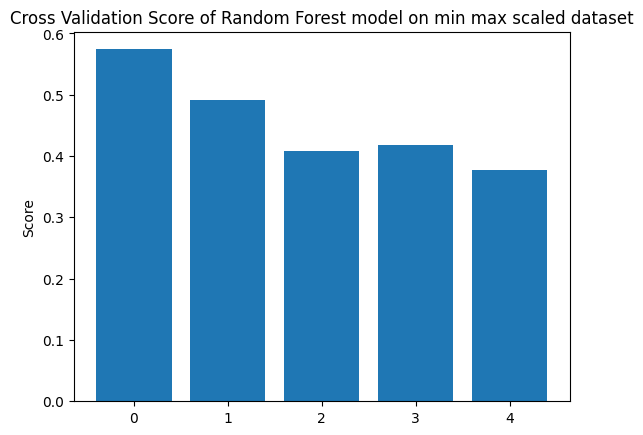

Mean= 0.4536384432936157 
Variance= 0.005063080564356494


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)
scores = cross_val_score(model, features_minmax, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest model on min max scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

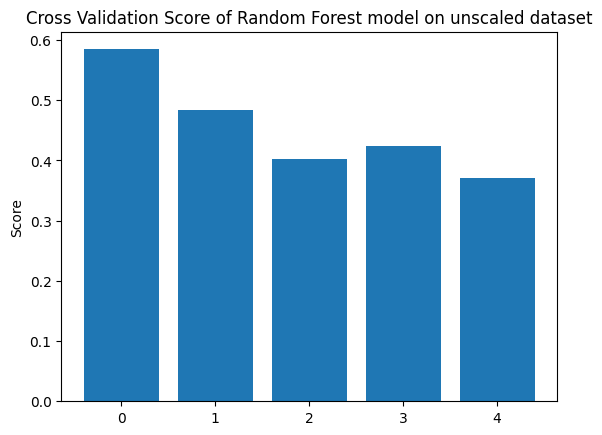

Mean= 0.45310653586515653 
Variance= 0.0056881636971525505


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)
scores = cross_val_score(model, features, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest model on unscaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

Summary:
- For Random Forest model, min max scaling is the best and the mean best test score is 45.3% after 5 cross validation.

### Hyperparameters Optimization

GridSearchCV is brute-force search over specified parameter values for an estimator. GridSearchCV has already implemented a “fit” and a “score” method. And it will run using the given params, e.g., models, scorling.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(
    n_estimators = 500,
    warm_start = True,
    oob_score = True,
    random_state=69
)
parameters = {
    'criterion':('gini', 'entropy'),
    "max_depth": range(1,100,20),
    "min_samples_leaf": range(1,100,30)
    }


grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, error_score="raise")
grid.fit(features_minmax, emotions)
# By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   0.9s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   0.8s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   0.8s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   0.8s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   0.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   0.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   0.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   0.9s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   0.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   0.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=61; total time=   0.8s
[CV] END ...criterion=gini, max_depth=1, min_sa

GridSearchCV(error_score='raise',
             estimator=RandomForestClassifier(n_estimators=500, oob_score=True,
                                              random_state=69,
                                              warm_start=True),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(1, 100, 20),
                         'min_samples_leaf': range(1, 100, 30)},
             verbose=2)

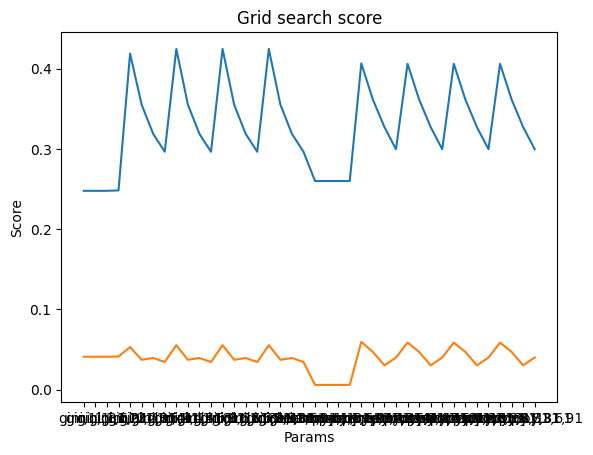

In [ ]:
def plot_grid_search(cv_results):
    params = cv_results["params"]
    x_names = []
    for dct in params:
        k = ",".join(str(v) for k,v in dct.items())
        # print(k)
        x_names.append(k)
    mean_test_scores = cv_results["mean_test_score"]
    std_test_scores = cv_results["std_test_score"]
    plt.plot(x_names, mean_test_scores, label="Mean")
    plt.plot(x_names, std_test_scores, label="Std")
    plt.title("Grid search score")
    plt.ylabel("Score")
    plt.xlabel("Params")
    plt.show()

plot_grid_search(grid.cv_results_)

Best params={'criterion': 'gini', 'max_depth': 41, 'min_samples_leaf': 1}, score=0.4245280900453314


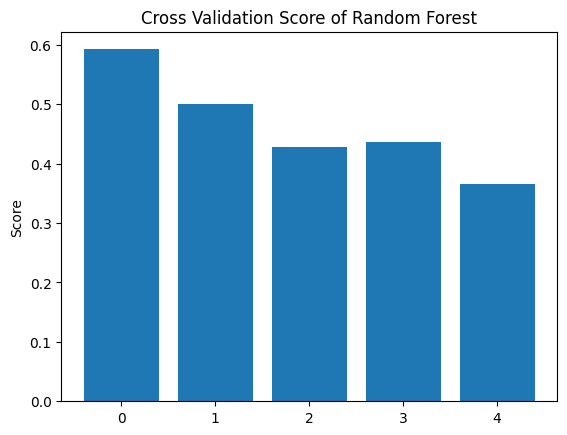

Mean= 0.4647439406060096 
Variance= 0.005886985809902544


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

print(f"Best params={grid.best_params_}, score={grid.best_score_}")

k_folds = KFold(n_splits = 5)
model = grid.best_estimator_
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")